In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import random
import requests
import zipfile
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import Categorical

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image_size = 128
batch_size = 512

In [ ]:
# The dataset provides 5 captions for each image, so we want to take a random one and use it
class SampleCaption(nn.Module):
    def __call__(self, sample):
        return sample[random.randint(0, len(sample) - 1)]

In [ ]:
# Transforms
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)])

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

In [ ]:
def download_url(url, save_path, chunk_size=1024):
  if os.path.exists(save_path):
    print(f"{save_path} already exists; skipping download.")
    return

  print(f"Downloading from {url} to {save_path} ...")
  response = requests.get(url, stream=True)
  total_size = int(response.headers.get('content-length', 0))

  with open(save_path, 'wb') as f:
    for data in response.iter_content(chunk_size=chunk_size):
      f.write(data)

  print("Download completed.")

def extract_zip(zip_path, extract_to):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get the top-level folder from the zip file
    folder_name = zip_ref.namelist()[0].split(os.sep)[0]
  target_path = os.path.join(extract_to, folder_name)

  if os.path.exists(target_path):
    print(f"{target_path} already exists; skipping extraction.")
    return

  print(f"Extracting {zip_path} to {extract_to} ...")

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

  print("Extraction completed.")

def get_train_dataset_paths(base_dir="./coco_dataset"):
  os.makedirs(base_dir, exist_ok=True)

  train_images_url = "http://images.cocodataset.org/zips/train2014.zip"
  ann_url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"

  train_zip_path = os.path.join(base_dir, "train2014.zip")
  ann_zip_path = os.path.join(base_dir, "annotations_trainval2014.zip")

  download_url(train_images_url, train_zip_path)
  download_url(ann_url, ann_zip_path)

  extract_zip(train_zip_path, base_dir)
  extract_zip(ann_zip_path, base_dir)

  train_images_folder = os.path.join(base_dir, "train2014")
  train_ann_file = os.path.join(base_dir, "annotations", "captions_train2014.json")

  # Verify that the required files exist
  if not os.path.isdir(train_images_folder):
      raise FileNotFoundError(f"Training images folder not found: {train_images_folder}")
  if not os.path.exists(train_ann_file):
      raise FileNotFoundError(f"Training annotation file not found: {train_ann_file}")

  return train_images_folder, train_ann_file

def get_val_dataset_paths(base_dir="./coco_dataset"):
  os.makedirs(base_dir, exist_ok=True)

  val_images_url = "http://images.cocodataset.org/zips/val2014.zip"
  ann_url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"

  val_zip_path = os.path.join(base_dir, "val2014.zip")
  ann_zip_path = os.path.join(base_dir, "annotations_trainval2014.zip")

  download_url(val_images_url, val_zip_path)
  download_url(ann_url, ann_zip_path)

  extract_zip(val_zip_path, base_dir)
  extract_zip(ann_zip_path, base_dir)

  val_images_folder = os.path.join(base_dir, "val2014")
  val_ann_file = os.path.join(base_dir, "annotations", "captions_val2014.json")

  # Verify that the required files exist
  if not os.path.isdir(val_images_folder):
      raise FileNotFoundError(f"Validation images folder not found: {val_images_folder}")
  if not os.path.exists(val_ann_file):
      raise FileNotFoundError(f"Validation annotation file not found: {val_ann_file}")

  return val_images_folder, val_ann_file

In [ ]:
train_images_folder, train_ann_file = get_train_dataset_paths()
print("Train Images Folder:", train_images_folder)
print("Train Annotation File:", train_ann_file)

val_images_folder, val_ann_file = get_val_dataset_paths()
print("Validation Images Folder:", val_images_folder)
print("Validation Annotation File:", val_ann_file)

Download completed.
Download completed.
Extracting ./coco_dataset/train2014.zip to ./coco_dataset ...
Extraction completed.
Extracting ./coco_dataset/annotations_trainval2014.zip to ./coco_dataset ...
Extraction completed.
Train Images Folder: ./coco_dataset/train2014
Train Annotation File: ./coco_dataset/annotations/captions_train2014.json
Download completed.
./coco_dataset/annotations_trainval2014.zip already exists; skipping download.
Extracting ./coco_dataset/val2014.zip to ./coco_dataset ...
Extraction completed.
./coco_dataset/annotations already exists; skipping extraction.
Validation Images Folder: ./coco_dataset/val2014
Validation Annotation File: ./coco_dataset/annotations/captions_val2014.json


In [ ]:
# Datasets
train_dataset = datasets.CocoCaptions(root=train_images_folder,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_images_folder,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [ ]:
# Dataloaders
train_dataloader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=0)
val_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             num_workers=0)

In [ ]:
first_iter = next(iter(val_dataloader))
test_images, test_captions = first_iter

test_images.shape # (batch_size=512, C=3, H=128, W=128)

torch.Size([512, 3, 128, 128])

two bunches of bananas one yellow and the other red 


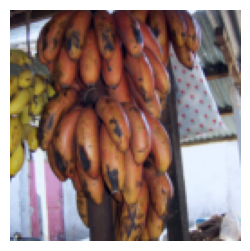

In [ ]:
plt.figure(figsize=(3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
plt.axis(False)
plt.imshow(out.numpy().transpose((1, 2, 0))) # Change to (H, W, C) for matplotlib display

caption = test_captions[0]
print(caption)

In [ ]:
# Use a pre-built tokenizer from BERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
print("[PAD] token id:", tokenizer.pad_token_id) # 0
print("[CLS] token id:", tokenizer.cls_token_id) # 101
print("[SEP] token id:", tokenizer.sep_token_id) # 102

[PAD] token id: 0
[CLS] token id: 101
[SEP] token id: 102


In [ ]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [ ]:
tokens["input_ids"].shape # (batch_size=512, seq_len=32)

torch.Size([512, 53])

In [ ]:
tokens["input_ids"][0].shape # (seq_len=32)

torch.Size([53])

In [ ]:
tokens['input_ids']

tensor([[  101,  2048,  9129,  ...,     0,     0,     0],
        [  101,  1037,  7146,  ...,     0,     0,     0],
        [  101,  2093, 29145,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  3065,  ...,  9850,  1012,   102],
        [  101,  1037,  2711,  ...,     0,     0,     0],
        [  101,  2045,  2024,  ...,     0,     0,     0]])

In [ ]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[  101,  2048,  9129,  ...,     0,     0,     0],
        [  101,  1037,  7146,  ...,     0,     0,     0],
        [  101,  2093, 29145,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  3065,  ...,  9850,  1012,   102],
        [  101,  1037,  2711,  ...,     0,     0,     0],
        [  101,  2045,  2024,  ...,     0,     0,     0]])

In [ ]:
print(tokenizer.decode(token_ids))

[CLS] two bunches of bananas one yellow and the other red [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
class TokenDrop(nn.Module):
  """
  For a batch of tokens indices, randomly replace a non-specical token for regularization
  """
  def __init__(self, prob=0.1, blank_token=1, eos_token=102):
    self.prob = prob
    self.eos_token = eos_token
    self.blank_token = blank_token

  def __call__(self, sample):
    # Randomly sample a bernoulli distribution with probability to create a mask where 1 means we will replace that token
    mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()

    # Only replace if the token is not the eos token
    can_drop = (~(sample == self.eos_token)).long() # ~ flips each element (We have to use it because we are working with 1.0 and 0.0)
    mask = mask * can_drop

    # Do not replace the [CLS] tokens (Set the first token of every sequence to 0)
    mask[:, 0] = torch.zeros_like(mask[:, 0]).long()

    # Create a tensor where every element is a blank token with a shape the same as sample
    replace_with = (self.blank_token * torch.ones_like(sample)).long()

    sample_out = (1 - mask) * sample + mask * replace_with

    return sample_out

**Model Architecture**


---



*Encoder: (Vision Transformer)*

Pass in the source image and and extract square patches from the image, flatten them, and pass pass them through a linear layer to get the embedded patches that have a size of d_model. Add the learned positional encodings.

In each encoder layer, pass in the src (patches) into the Q, K, and V values of a Multi-Head Attention. We then do a residual addition and layer norm.

We then pass the output of the Attention block into a Position-Wise Feedforward Network and do a residual addition and layer norm.

The output of the final encoder block is then used in Cross-Attention of the Decoder.



---



*Decoder: (Standard Text Decoder)*

Pass in the tokenized target sequence and add the sinusoidal positional encodings.

Pass in the embedding (trg), and output of Encoder Layer (src) into each decoder layer.

In each decoder layer, pass in the trg into the Q, K, and V values, and a generated target mask into the mask value of Masked Multi-Head Attention. We then do a residual addition and layer norm.

Now, pass in the output of Masked Multi-Head Attention into Cross-Attention for the Q value, and the src for K and V. Do not pass in a source mask. We then do a residual addition and layer norm.

Lastly, we pass the output of Cross-Attention into a Position-Wise Feedforward Network and do a residual addition and layer norm.

Then, we do a final linear layer at the end of the final decoder block.

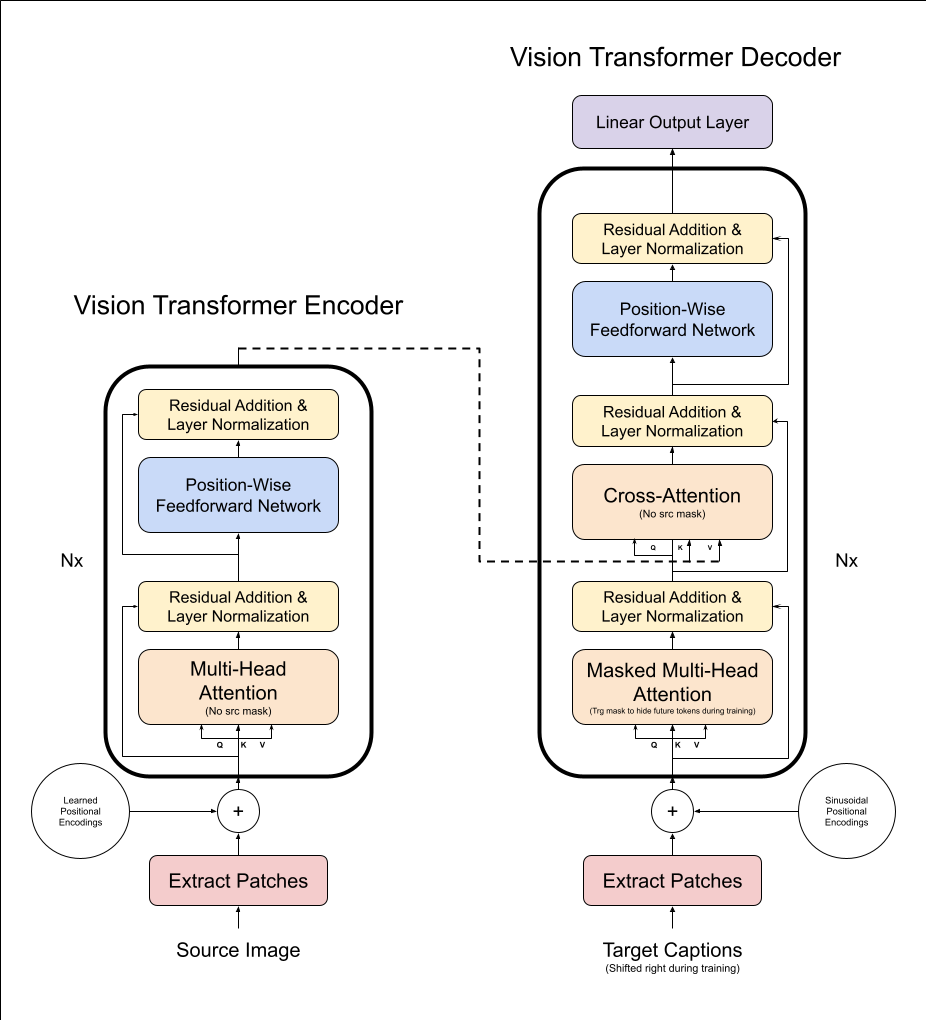

In [ ]:
class ExtractPatches(nn.Module):
  def __init__(self, patch_size: int = 16):
    super().__init__()

    self.patch_size = patch_size
    self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    batch_size, c, h, w = x.shape

    # Unfold applies a slding window to generate patches
    # The transpose and reshape change the shape to (batch_size, num_patches, 3 * patch_size * patch_size), flattening the patches
    return self.unfold(x).transpose(1, 2).reshape(batch_size, -1, c * self.patch_size * self.patch_size)

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    """
    super().__init__()

    # Intead of precomputing fixed values, we will compute in the forward pass based off of the sinusodiual encoding formula
    self.d_model = d_model

  def forward(self, x):
    device = x.device
    half_dim = self.d_model // 2 # Use half for sin and half for cos
    emb = math.log(10000.0) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = x[:, None] * emb[None, :] # (batch_size, half_dim)
    emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
    return emb

In [ ]:
# Multi-Head Self-Attention
class MultiHeadAttention(nn.Module):
  def __init__(self,
               d_model: int = 512,
               n_heads: int = 8,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()
    assert d_model % n_heads == 0 # We want to make sure that the dimensions are split evenly among the attention heads.
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_key = d_model // n_heads

    self.Wq = nn.Linear(d_model, d_model) # Learnable weights for query
    self.Wk = nn.Linear(d_model, d_model) # Learnable weights for key
    self.Wv = nn.Linear(d_model, d_model) # Learnable weights for value
    self.Wo = nn.Linear(d_model, d_model) # Learnable weights for output

    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              query,
              key,
              value,
              mask = None):
    """
    query: (batch_size, q_length, d_model)
    key: (batch_size, k_length, d_model)
    value: (batch_size, s_length, d_model)
    """
    batch_size = key.size(0)

    # Matrix multiplication for Q, K, and V tensors
    Q = self.Wq(query)
    K = self.Wk(key)
    V = self.Wv(value)

    # Split each tensor into heads
    Q = Q.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, q_length, d_key)
    K = K.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, k_length, d_key)
    V = V.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, v_length, d_key)

    # Scaled dot product
    scaled_dot_product = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_key) # K^T becomees (batch_size, n_heads, d_key, k_length)

    if mask is not None:
      scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -float("inf")) # Filling it with 0 would result in 1 after the mask because e^0 = 1. Intead we fill it with an infinitley large negative number

    # Softmax function for attention probabilities
    attention_probs = torch.softmax(scaled_dot_product, dim=-1)

    # Multiply by V to get attention with respect to the values
    A = torch.matmul(self.dropout(attention_probs), V)

    # Reshape attention back to (batch_size, q_length, d_model)
    A = A.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.n_heads * self.d_key)

    # Pass through the final linear layer
    output = self.Wo(A)

    return output, attention_probs # Output shape: (batch_size, q_length, d_model), Attention probs shape: (batch_size, n_heads, q_length, k_length)

In [ ]:
# Position-Wise Feed Forward Network (FFN)
class PositionwiseFeedForward(nn.Module):
  def __init__(self,
               d_model: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    dropout: probability of dropout
    """
    super().__init__()

    self.ffn = nn.Sequential(
        nn.Linear(in_features=d_model, out_features=(d_model * 4)),
        nn.ReLU(),
        nn.Linear(in_features=(d_model * 4), out_features=d_model),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    return self.ffn(x)

In [ ]:
# Encoder Layer
class EncoderLayer(nn.Module):
  def __init__(self,
               d_model: int,
               n_heads: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()

    # Multi-Head Self-Attention sublayer
    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Position-wise Feed-forward Network
    self.position_wise_ffn = PositionwiseFeedForward(d_model=d_model, dropout=dropout)
    self.ffn_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    self.dropout = nn.Dropout(p=dropout)

  def forward(self, src):
    """
    src: embedded sequences (batch_size, seq_length, d_model)
    """
    # Multi-Head Attention

    _src, attention_probs = self.attention(src, src, src, None) # Q, K, V, src_mask: we don't need a source mask because all images are the same dimension

    # Residual Addition and Layer Normalization
    src = self.attention_layer_norm(src + self.dropout(_src)) # We do residual addition by adding back the src (the embeddings) to the output of Self-Attention

    # Position-wise Feed-forward Network
    _src = self.position_wise_ffn(src)

    # Residual Addition and Layer Normalization
    src = self.ffn_layer_norm(src + self.dropout(_src))

    return src, attention_probs

In [ ]:
# The Encoder that takes in images and returns the encoding to be passed into the decoder
class Encoder(nn.Module):
  def __init__(self,
               image_size: int,
               channels_in: int,
               patch_size: int = 16,
               d_model: int = 128,
               n_layers: int = 3,
               n_heads: int = 4,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_layers: number of encoder layers in the encoder block
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()

    self.patch_size = patch_size

    self.extract_patches = ExtractPatches(patch_size=patch_size)
    self.fc_in = nn.Linear(channels_in * patch_size * patch_size, d_model)

    seq_length = (image_size // patch_size)**2

    # Image src is going to use a learnable positional encoding
    self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, d_model).normal_(std=0.02))

    # Create n_layers encoders
    self.layers = nn.ModuleList([EncoderLayer(d_model=d_model, n_heads=n_heads, dropout=dropout) for layer in range(n_layers)])
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, src):
    """
    src: embedded sequences (batch_size, seq_length, d_model)
    """

    # Extract the patches and apply a linear layer
    batch_size = src.shape[0]
    src = self.fc_in(self.extract_patches(src))

    # Add the learned positional embedding
    src = src + self.pos_embedding

    # Pass the sequences through each encoder layer
    for layer in self.layers:
      src, attention_probs = layer(src)

    self.attention_probs = attention_probs

    return src

In [ ]:
# Decoder Layer
class DecoderLayer(nn.Module):
  def __init__(self,
               d_model: int,
               n_heads: int,
               dropout: float = 0.1):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()

    # Masked Multi-Head Self-Attention sublayer
    self.masked_attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.masked_attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Multi-Head Self-Attention sublayer
    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    self.attention_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    # Position-wise Feed-forward Network
    self.position_wise_ffn = PositionwiseFeedForward(d_model=d_model, dropout=dropout)
    self.ffn_layer_norm = nn.LayerNorm(d_model) # Layer normalization

    self.dropout = nn.Dropout(p=dropout)

  def forward(self,
              trg,
              src,
              trg_mask):
    """
    trg: embedded captions (batch_size, trg_seq_length, d_model)
    src: embedded images (batch_size, src_seq_length, d_model)
    trg_mask: mask for the captions preventing peeking at future tokens (batch_size, 1, trg_seq_length, trg_seq_length)
    """

    # Masked Multi-Head Attention

    # The target mask is used to prevent the model from seeing future tokens. This ensures that the prediction is made solely based on past and present tokens.
    _trg, masked_attention_probs = self.masked_attention(trg, trg, trg, trg_mask) # Q, K, V, mask

    # Residual Addition and Layer Normalization
    trg = self.masked_attention_layer_norm(trg + self.dropout(_trg))

    # Multi-Head Attention - This time, we also pass in the output of the encoder layers as src.
    # This is important because this allows us to keep track of and learn relationships between the input and output tokens.
    _trg, attention_probs = self.attention(trg, src, src, None) # Q, K, V, mask
    # Residual Addition and Layer Normalization
    trg = self.attention_layer_norm(trg + self.dropout(_trg))

    # Position-wise Feed-forward Network
    _trg = self.position_wise_ffn(trg)
    # Residual Addition and Layer Normalization
    trg = self.ffn_layer_norm(trg + self.dropout(_trg))

    return trg, attention_probs, masked_attention_probs

In [ ]:
# The Decoder Module that takes the encoded images from the encoder and generates captions
class Decoder(nn.Module):
  def __init__(self,
               vocab_size: int,
               d_model: int = 128,
               n_layers: int = 3,
               n_heads: int = 4,
               dropout: float = 0.1):
    """
    vocab_size: size of the target vocabulary
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    n_layers: number of encoder layers in the encoder block
    n_heads: number of self attention heads per sequence
    dropout: probability of dropout
    """
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, d_model)

    self.embedding.weight.data = 0.001 * self.embedding.weight.data

    # Initialize sinusoidal positional embeddings
    self.pos_emb = PositionalEncoding(d_model=d_model)

    # Create n_layers decoders
    self.layers = nn.ModuleList([DecoderLayer(d_model=d_model, n_heads=n_heads, dropout=dropout) for layer in range(n_layers)])
    self.dropout = nn.Dropout(p=dropout)

    # Output layer
    self.Wo = nn.Linear(in_features=d_model, out_features=vocab_size)

  def make_trg_mask(self, trg):
    seq_length = trg.shape[1]

    trg_mask = torch.tril(torch.ones((seq_length, seq_length), device=trg.device)).bool()

    return trg_mask.unsqueeze(0).unsqueeze(0) # (batch_size=1, n_heads=1, seq_length, seq_length)

  def forward(self,
              trg,
              src):
    """
    trg: target sequences (batch_size, trg_seq_length, d_model)
    src: embedding images (batch_size, src_seq_length, d_model)
    """

    # Embed the target captions
    trg = self.embedding(trg)
    batch_size, l, h = trg.shape

    trg_index = torch.arange(l, device=trg.device)
    pos_emb = self.pos_emb(trg_index).reshape(1, l, h).expand(batch_size, l, h)
    # Add the fixed sinusodial positional embedding
    trg += pos_emb

    # Create a target mask for the target captions to prevent the model from peeking at future tokens
    trg_mask = self.make_trg_mask(trg) # (batch_size, 1, trg_seq_length, trg_seq_length)

    # Pass the sequences through each decoder layer
    for layer in self.layers:
      trg, attention_probs, masked_attention_probs = layer(trg, src, trg_mask)

    self.attention_probs = attention_probs
    self.masked_attention_probs = masked_attention_probs # (batch_size, n_heads, trg_seq_len, src_seq_len) trg_seq_len: length of the target caption \ src_seq_len: number of patches from the encoder

    # Final linear output layer
    return self.Wo(trg)

In [ ]:
class CaptioningTransformer(nn.Module):
  def __init__(self,
               image_size: int,
               channels_in: int,
               vocab_size: int,
               device,
               patch_size: int = 16,
               d_model: int = 128,
               n_layers: int = 3,
               n_heads: int = 4):
      super().__init__()

      self.device = device

      # Create an encoder and decoder with specified parameters
      self.encoder = Encoder(image_size=image_size,
                             channels_in=channels_in,
                             patch_size=patch_size,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads)

      self.decoder = Decoder(vocab_size=vocab_size,
                             d_model=d_model,
                             n_layers=n_layers,
                             n_heads=n_heads)

  def forward(self, src, trg):
    # Encoder layers
    src = self.encoder(src)  # (batch_size, src_seq_length, d_model)

    # Decoder layers
    output = self.decoder(trg, src) # Pass in both the target (for Masked Multi-Head Self-Attention) and source for (Cross-Attention)

    return output

In [ ]:
d_model = 192 # Dimensioniality of embedded tokens
n_layers = 6 # Number of Encoder and Decoder layers
n_heads = 8 # Number of heads for Attention
patch_size = 8 # Image size of 128x128 leads to 256 image patches per image with a patch_size=8

lr = 0.0005
epochs = 10

model = CaptioningTransformer(image_size=image_size,
                             channels_in=test_images.shape[1],
                             vocab_size=tokenizer.vocab_size,
                             device=device,
                             patch_size=patch_size,
                             n_layers=n_layers,
                             d_model=d_model,
                             n_heads=n_heads).to(device)

optimizer = optim.AdamW(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss(reduction="none")

scaler = torch.cuda.amp.GradScaler() # Apply gradient scaling to mitigate vanishing gradients problem
td = TokenDrop(0.25)

<ipython-input-77-1117236eb27d>:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
num_model_params = 0
for param in model.parameters():
  num_model_params += param.flatten().shape[0]

print(f"This model has {num_model_params} parameters")

This model has 18067194 parameters


In [ ]:
train_model = False

model_path = "image_captioning_model.pt"
if os.path.exists(model_path):
  print(f"Loading model from {model_path}...")
  model.load_state_dict(torch.load(model_path, map_location=device))

Loading model from image_captioning_model.pt...


<ipython-input-102-fd5c9d658440>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Let's say that we have a target of: "**[CLS] the big red bus [SEP]**". For simplicity, let’s say that we have a batch size of 1, a sequence length of 6 tokens, a d_model of 192, and 8 attention heads. This means that key and query has a dimension of 24.

Using teacher forcing, the input to the decoder is "[CLS] the big red bus", and the model is trained to predict "the big red bus [SEP]".

We can pass the text through the tokenizer (for this example it will be the BERT tokenizer) to get a sequence of `[101, 11, 57, 234, 89, 102]`, where 101 represents [CLS] and 102 represents [SEP]. This sequence has a shape of **`(batch_size=1, seq_len=6)`**.

**Teacher forcing means that we use the true target value to predict the next token. This has many benefits as in training, we just want to worry about predicting the next word, so this allows us to more accurately calculate the loss and converge on a minimum loss faster.**

After the tokens are passed through the embedding layer and positional encodings are added, they have a shape of `(batch_size=1, seq_len=6, d_model=192)`.

During the decoder layer, we generate a target mask with the lower triangle being set to 1. This should have a shape of `(batch_size=1, n_heads=1, seq_len=6, seq_len=6)`.

$$
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 & 0 \\1 & 1 & 1 & 0 & 0 \\1 & 1 & 1 & 1 & 0 \\1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
$$

This means that for the first sequence, we want to predict the next word only being given [CLS]. For the second sequence, we want to predict the next word only being given [CLS] the.

During Masked Multi-Head Attention, we first split the d_model into n_heads. This gives us a size of `(batch_size=1, n_heads=8, seq_len=6, d_model=24)`. Next, we compute the scaled dot product between $Q$ and $K^T$. Multiplying Q (batch_size=1, n_heads=8, seq_len=6, d_model=24) and $K^T$ (batch_size=1, n_heads=8, d_model=24, seq_len=6), gives us a shape of `(batch_size=1, n_heads=8, seq_len=6, seq_len=6)`. Each score is also divided by $\sqrt{24}$ to stabilize gradients.

In the target mask, wherever the mask is 0 (indicating future positions), the corresponding score is set to a large negative value (like $- \infty$) so that after softmax the probability becomes zero.

Applying the target mask to the scaled dot product, gives us a matrix with the same size of`(batch_size=1, n_heads=8, seq_len=6, seq_len=6)`, but with the positions that we want to be masked.

This means that for every head, we have 6 sequences each with a sequence length of 6, with each row having an increasing number of tokens that it uses to predict the next word.

The matrix at this point would look something like this for every head:

$$
\begin{bmatrix}
[CLS] & - \infty & - \infty & - \infty & - \infty \\
[CLS] & the & - \infty & - \infty & - \infty \\ [CLS] & the & big & - \infty & - \infty \\ [CLS] & the & big & red & - \infty \\ [CLS] & the & big & red & bus \\
\end{bmatrix}
$$

**(Note that where we have the name of each token is instead just the attention score for that specific token.)**

We can then apply the softmax over the last dimension (the tokens in each row). The positions that have $- \infty$ are set to 0 through the softmax function.

We then multiply the attention scores which have a shape of (batch_size=1, n_heads=8, seq_len=6, seq_len=6) by the V matrix which has a shape of (batch_size=1, n_heads=8, seq_len=6, d_model=24). This results in a weighted sum for each token with a shape of `(batch_size=1, n_heads=8, seq_len=6, d_model=24)`.

When the attention scores are multiplied by the V matrix, at each row of the output matrix of the softmax function, each score is multiplied by a value from the V matrix. This gives us a new matrix, where each row is a 24 dimensional vector that encodes the context for the specific token.

For example, let’s denote the values of the V vector at a certain head as: `[v0, v1, v2, v3, v4, v5]`, where each $v_i$ is 24 dimensions. Let’s say that the attention mechanism produces these values as outputs of the softmax function at a certain token: `[a0 = 0.50, a1 = 0.30, a2 = 0.20, a3 = 0.00, a4 = 0.00, a5 = 0.00]`. This means that at this position, the model is allowed to see only tokens 0, 1, and 2 because of the target mask. The weighted sum for token this token in its head is computed as : $\text{output}[3] = 0.50 \times v0 + 0.30 \times v1 + 0.20 \times v2$

Lastly, we concatenate the heads and permute which gives us a final shape of `(batch_size=1, seq_len=6, d_model=192)`: the same shape as the original.

Although the causal mask prevents each token from seeing “future” tokens, the decoder processes the entire sequence in one forward pass. This means that it computes output representations for all time steps in parallel.

In [ ]:
best_loss = float('inf')

if train_model:
  for epoch in trange(0, epochs, leave=False, desc="Epoch"):
    model.train()

    epoch_loss = 0
    for images, captions in tqdm(train_dataloader, desc="Training", leave=False):
      images = images.to(device)

      # Tokenize the target captions
      tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
      token_ids = tokens['input_ids'].to(device)
      attention_mask = tokens["attention_mask"].to(device) # Use the padding mask to ignore padding tokens so that the loss isn't penialized by it

      input_tokens = token_ids[:, :-1] # Get rid of the end-of-sequence token from each sequence because we want to predict it
      target_ids = token_ids[:, 1:] # Get rid of the start-of-sequence token from each sequence because it is not predicted by the model (we want it to match up with the predicted tokens for the loss calculation)
      target_mask = attention_mask[:, 1:] # Get rid of the start-of-sequence token from each sequence in the attention mask to match the attention mask with the target_ids

      tokens_in = td(input_tokens)

      # Switch to lower precision floats for certain tasks for faster computations
      with torch.cuda.amp.autocast():
        # Forward pass

        # For each sequence, every word in the last dim for vocab_size has a prob corresponding to each token.
        # The target mask is used for teacher forcing when the target sequence is put over the target mask to get a matrix that represents the different sequences that we use for the trgs. Each new row of the matrix is a sequence with one more word for teacher forcing.
        pred = model(images, tokens_in) # Shape: (batch_size, trg_seq_len, vocab_size)

      # Transpose makes the shape of the preds: (batch_size, vocab_size, trg_seq_len) We need to do this because CrossEntropyLoss wants second dimension to be vocab_size
      loss = (loss_fn(pred.transpose(1, 2), target_ids) * target_mask).mean() # Multiply by the target mask because we want the loss to only be calculated on the valid non-padding tokens

      epoch_loss += loss.item()

      # Optimizer Zero Grad
      optimizer.zero_grad()
      # Backpropagation
      scaler.scale(loss).backward()
      # Optimizer Step
      scaler.step(optimizer)
      scaler.update()

    epoch_loss /= len(train_dataloader)

    message = f"Epoch: {epoch + 1} | Loss: {epoch_loss:.5f}"

    if epoch_loss < best_loss:
      best_loss = epoch_loss
      torch.save(model.state_dict(), model_path)
      message += " --> STORED"

    print(message)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/162 [00:00<?, ?it/s]

<ipython-input-80-a2b0d0d93ec8>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 1 | Loss: 1.22564 --> STORED


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 2 | Loss: 1.17549 --> STORED


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 3 | Loss: 1.17123 --> STORED


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 4 | Loss: 1.16973 --> STORED


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 5 | Loss: 1.18074


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 6 | Loss: 1.11660 --> STORED


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 7 | Loss: 1.12893


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 8 | Loss: 1.16862


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 9 | Loss: 1.14118


Training:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch: 10 | Loss: 1.11600 --> STORED


In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
val_dataiter = next(iter(val_dataloader))

test_images, test_captions = val_dataiter

In [ ]:
test_image = test_images[0].unsqueeze(0)

A train with a red and yellow engine on a railroad track.


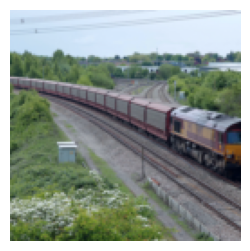

In [ ]:
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
plt.axis(False)
plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[0])

In [ ]:
# Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()

# Set the temperature for sampling during generation
temp = 0.5

In [ ]:
def make_prediction(model, sos_token, eos_token, image, max_len, temp, device):
  log_tokens = [sos_token] # Start with the start-of-sequence token
  model.eval()

  with torch.inference_mode():
    # Use the encoder and decoder seperateley so that we can avoid re-computting the image_embeddings every forward pass through the transformer

    with torch.cuda.amp.autocast():
      # Pass the image through the encoder to get the image embeddings
      image_embedding = model.encoder(image.to(device)) # Encoder Output Shape: (1, num_patches, d_model)

    # Generate the target caption tokens
    for i in range(max_len):
      input_tokens = torch.cat(log_tokens, 1)

      # Trg: current target captions, Src: Image Embeddings
      data_pred = model.decoder(input_tokens.to(device), image_embedding)
      # Data pred shape: (batch_size=1, seq_length, vocab_size)

      # Randomly sample based off of the probabilities (highest prob has highest chance of being chosen), and get the predicted token from the vocab_size
      dist = Categorical(logits=data_pred[:, -1] / temp) # Take the logits for the last token (newly generated token) from the output; Shape: (1, vocab_size)
      next_tokens = dist.sample().reshape(1, 1)

      log_tokens.append(next_tokens.cpu())

      if next_tokens.item() == eos_token:
        break

  return log_tokens

In [ ]:
log_tokens = make_prediction(model=model,
                             sos_token=sos_token,
                             eos_token=102,
                             image=test_image,
                             max_len=50,
                             temp=temp,
                             device=device)

<ipython-input-114-3ab904375ef3>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [ ]:
pred_text = torch.cat(log_tokens, 1)
print(pred_text)

decoded_text = tokenizer.decode(pred_text[0], skip_special_tokens=True) # Decode the target tokens

tensor([[  101,  1037,  3345,  7118,  2091,  3162,  2083,  1037,  3541, 10833,
          1012,   102]])


a train traveling down tracks through a rural countryside.


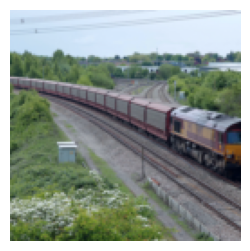

In [ ]:
print(decoded_text)

plt.figure(figsize=(3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
plt.axis(False)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
def random_pred(dataloader, loader_index, model, sos_token, temp, device):
  data_iter = next(iter(dataloader))

  images, captions = data_iter

  image = images[loader_index].unsqueeze(0)
  caption = captions[loader_index]

  plt.figure(figsize = (3,3))
  out = torchvision.utils.make_grid(image, 1, normalize=True)
  plt.axis(False)
  plt.imshow(out.numpy().transpose((1, 2, 0)))
  print(f"True: {caption}")

  log_tokens = make_prediction(model=model,
                               sos_token=sos_token,
                               eos_token=102,
                               image=image,
                               max_len=50,
                               temp=temp,
                               device=device)
  pred_text = torch.cat(log_tokens, 1)
  decoded_text = tokenizer.decode(pred_text[0], skip_special_tokens=True)

  print(f"Pred: {decoded_text}")

True: A man with a racket plays on a court.
Pred: a man in a blue shirt playing tennis.


<ipython-input-114-3ab904375ef3>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


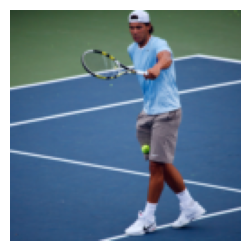

In [ ]:
random_pred(dataloader=val_dataloader,
            loader_index=1,
            model=model,
            sos_token=sos_token,
            temp=temp,
            device=device)